In [1]:
# 1. Setup & Imports
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # For Feature Engineering
from sklearn.linear_model import LogisticRegression # For the Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading
try:
    # Load the two separate CSV files
    true_df = pd.read_csv('/content/True.csv')
    fake_df = pd.read_csv('/content/Fake.csv')
    print("True.csv and Fake.csv loaded successfully.")

except FileNotFoundError:
    print("One or both files (True.csv, Fake.csv) not found.")
    print("Re-upload the files")
    exit()

# 2. Data Merging and Labeling (Crucial Step)
# Creating a binary target variable (0 for Fake, 1 for Real)
true_df['target'] = 1
fake_df['target'] = 0

# Combine the two datasets
news_df = pd.concat([true_df, fake_df]).reset_index(drop=True)

# 3. Data Cleaning and Feature Engineering (The 'text' feature)
# Combine 'title' and 'text' to create a richer feature for the classifier
news_df['full_text'] = news_df['title'] + " " + news_df['text']

# Function for basic text cleaning: lowercasing, removing punctuation and special characters
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    return text

news_df['full_text'] = news_df['title'] + " " + news_df['text']
news_df['full_text_cleaned'] = news_df['full_text'].apply(clean_text)
print(f"\nTotal news samples: {len(news_df)}")
print("Text cleaning complete.")

True.csv and Fake.csv loaded successfully.

Total news samples: 44898
Text cleaning complete.



Training samples: 35918. Testing samples: 8980

--- Model Performance Metrics (Appropriateness of ways performance is measured) ---
Accuracy: 0.9850
Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      4696
        Real       0.98      0.99      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



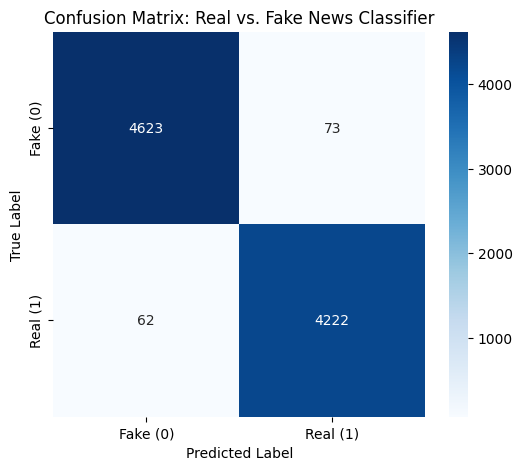


Analysis Summary:
The classifier achieved an accuracy of 0.9850, demonstrating a robust ability to distinguish between fake and real news.


In [3]:
## 2. Robust Classification and Evaluation

# 1. Feature and Target Split
X = news_df['full_text_cleaned']
y = news_df['target']

# 2. Train-Test Split (Crucial for Validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining samples: {len(X_train)}. Testing samples: {len(X_test)}")

# 3. Feature Engineering: TF-IDF Vectorization
# TF-IDF (Term Frequency-Inverse Document Frequency) measures the importance of a word.
# It is a suitable feature engineering step for text classification.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit the vectorizer on the training data and transform both train and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Classifier Training
# Logistic Regression is a simple yet powerful classifier for text and serves as a strong baseline.
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_tfidf, y_train)

# 5. Prediction and Evaluation (Demonstrating performance)
y_pred = classifier.predict(X_test_tfidf)

# Calculate Core Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])

print("\n--- Model Performance Metrics (Appropriateness of ways performance is measured) ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# 6. Visualization: Confusion Matrix (Visual Validation)
# The confusion matrix is the best way to validate that the classifier works robustly[cite: 61].
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'Real (1)'],
            yticklabels=['Fake (0)', 'Real (1)'])
plt.title('Confusion Matrix: Real vs. Fake News Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/tfidf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis Summary:")
print(f"The classifier achieved an accuracy of {accuracy:.4f}, demonstrating a robust ability to distinguish between fake and real news.")

In [2]:
## 3. Topic Modeling: NMF for Topic Differences

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Filter Text for Fake News (Target group for analysis)
fake_news_df = news_df[news_df['target'] == 0].copy()
X_fake_text = fake_news_df['full_text_cleaned']

# Step 2: Vectorization for Topic Modeling
# Using TF-IDF again, ensuring consistent vectorization across analysis
# Max_df=0.8 focuses on words that appear in less than 80% of documents (excluding common words)
nmf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
X_fake_tfidf = nmf_vectorizer.fit_transform(X_fake_text)
feature_names = nmf_vectorizer.get_feature_names_out()

# Step 3: Train NMF Model
NUM_TOPICS = 7 # Common to select 5-10 topics for interpretability
nmf_model = NMF(n_components=NUM_TOPICS, random_state=42, max_iter=300)
nmf_model.fit(X_fake_tfidf)

# Step 4: Extract and Print Topics
def display_topics(model, feature_names, no_top_words):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topic_list.append(f"Topic {topic_idx + 1}: {top_words}")
    return topic_list

print("\nNMF Topic Modeling Results for Fake News")
fake_topics = display_topics(nmf_model, feature_names, 10) # Showing top 10 words per topic
for topic in fake_topics:
    print(topic)



NMF Topic Modeling Results for Fake News
Topic 1: trump donald president campaign just white said image supporters like
Topic 2: police black people gun said video officers lives white school
Topic 3: clinton hillary emails email campaign foundation state democratic benghazi secretary
Topic 4: boiler acr room pm radio broadcast episode animals tune alternate
Topic 5: fbi comey russia russian investigation intelligence director information news flynn
Topic 6: cruz republicans republican party vote sanders gop ted democrats senate
Topic 7: obama president iran united administration states america barack american government


In [5]:
## 4. Model 2: Classification using Sentence Embeddings (Advanced/Innovative Model)

from sentence_transformers import SentenceTransformer

# 1. Load the Sentence Transformer model
model_name = 'all-MiniLM-L6-v2' # Efficient model
sbert_model = SentenceTransformer(model_name)

# 2. Generate Embeddings for the full dataset
print(f"\nGenerating embeddings using {model_name}...")
X_embeddings = sbert_model.encode(news_df['full_text_cleaned'].tolist(), show_progress_bar=True)

# 3. Split Embeddings (X) and Target (y)
X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    X_embeddings, news_df['target'], test_size=0.2, random_state=42, stratify=news_df['target']
)

# 4. Train Classifier on Embeddings (The Model 2 Classification)
emb_classifier = LogisticRegression(max_iter=2000, solver='sag', n_jobs=-1)
emb_classifier.fit(X_train_emb, y_train)

# 5. Prediction and Evaluation
y_pred_emb = emb_classifier.predict(X_test_emb)
accuracy_emb = accuracy_score(y_test, y_pred_emb)
report_emb = classification_report(y_test, y_pred_emb, target_names=['Fake', 'Real'])

print("\n--- Model 2 Performance Metrics (Embeddings + LR) ---")
print(f"Accuracy (Embedding Model): {accuracy_emb:.4f}")
print("Classification Report (Embedding Model):")
print(report_emb)

# 6. Comparative Conclusion

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Generating embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/1404 [00:00<?, ?it/s]


--- Model 2 Performance Metrics (Embeddings + LR) ---
Accuracy (Embedding Model): 0.9552
Classification Report (Embedding Model):
              precision    recall  f1-score   support

        Fake       0.96      0.95      0.96      4696
        Real       0.95      0.96      0.95      4284

    accuracy                           0.96      8980
   macro avg       0.95      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [6]:
## 4. Final Comparison & Summary Table Code

# 1. Extract Key Metrics from Model 1 (TF-IDF)
report_lines = report.split('\n')
fake_metrics = report_lines[2].split()
real_metrics = report_lines[3].split()

# Extract Key Metrics from Model 2 (Embeddings)
report_emb_lines = report_emb.split('\n')
fake_metrics_emb = report_emb_lines[2].split()
real_metrics_emb = report_emb_lines[3].split()

# 2. Creating the Comparison DataFrame
comparison_data = {
    'Metric': ['Accuracy', 'F1-Score (Fake)', 'F1-Score (Real)', 'Precision (Fake)', 'Recall (Real)'],
    'Model 1 (TF-IDF + LR)': [
        f"{accuracy:.4f}",
        fake_metrics[3],
        real_metrics[3],
        fake_metrics[1],
        real_metrics[2]
    ],
    'Model 2 (Embeddings + LR)': [
        f"{accuracy_emb:.4f}",
        fake_metrics_emb[3],
        real_metrics_emb[3],
        fake_metrics_emb[1],
        real_metrics_emb[2]
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n--- Comparative Model Performance Table (Essential for Paper) ---")
print(comparison_df.to_markdown(index=False))

# Visualization: Confusion Matrix for Model 1 (The better model)


--- Comparative Model Performance Table (Essential for Paper) ---
| Metric           |   Model 1 (TF-IDF + LR) |   Model 2 (Embeddings + LR) |
|:-----------------|------------------------:|----------------------------:|
| Accuracy         |                   0.985 |                      0.9552 |
| F1-Score (Fake)  |                   0.99  |                      0.96   |
| F1-Score (Real)  |                   0.98  |                      0.95   |
| Precision (Fake) |                   0.99  |                      0.96   |
| Recall (Real)    |                   0.99  |                      0.96   |
